# Lab_4 TCV3151 Computer Vision
Bagja 9102 Kurniawan <br> **1211501345**

## Preparatory Work

In [1]:
#Mount Google Drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#Import the packages.
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Question 1: Implement Noise Model

In [3]:
#Define the function for generating noise.
def noise_generator (noise_type,image):
    (row,col,ch) = image.shape
    if noise_type == 'gauss':       
        mean = 0.0
        var = 0.15
        sigma = var**0.5
        gauss = np.array(image.shape)
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy.astype('uint8')
    elif noise_type == 's&p':
        s_vs_p = 0.5
        amount = 0.004
        out = image
        # Generate Salt '1' noise
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 255
        # Generate Pepper '0' noise
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_type == 'uniform':
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy
    else:
        return image

(<matplotlib.image.AxesImage at 0x7f4822dc9ad0>, (-0.5, 399.5, 383.5, -0.5))

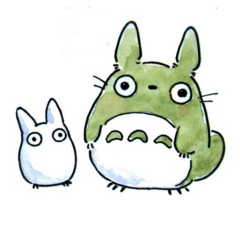

In [4]:
#Read the Totoro image.
path = '/content/gdrive/My Drive/TCV3151/Lab_4/'
 
img = cv2.imread(path + 'totoro.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img), plt.axis('off')

##### Add Noises

(<matplotlib.image.AxesImage at 0x7f4814be77d0>, (-0.5, 399.5, 383.5, -0.5))

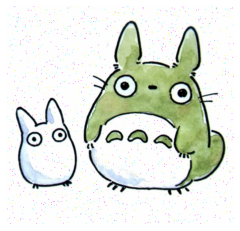

In [5]:
# Add Gaussian noise
gauss_img = noise_generator('gauss', img)
plt.imshow(gauss_img), plt.axis('off')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(<matplotlib.image.AxesImage at 0x7f4814bbde10>, (-0.5, 399.5, 383.5, -0.5))

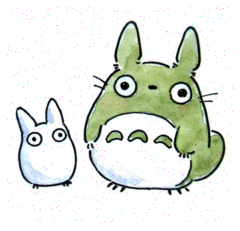

In [6]:
# Add salt and pepper noise
sp_img = noise_generator("s&p", img)
plt.imshow(sp_img), plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x7f4814b19c90>, (-0.5, 399.5, 383.5, -0.5))

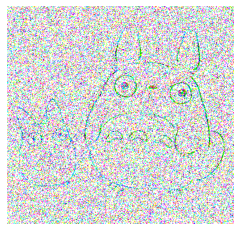

In [7]:
# Add uniform noise
uniform_img = noise_generator("uniform", img)
plt.imshow(uniform_img), plt.axis('off')

## Question 2: Noise Reduction

(<matplotlib.image.AxesImage at 0x7f4814b01390>, (-0.5, 399.5, 383.5, -0.5))

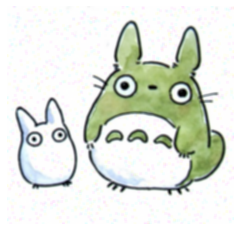

In [8]:
# Improve Gaussian noise by using average filter
improved_gauss_img = cv2.blur(gauss_img, (5,5))
plt.imshow(improved_gauss_img), plt.axis('off')

(<matplotlib.image.AxesImage at 0x7f4814a589d0>, (-0.5, 399.5, 383.5, -0.5))

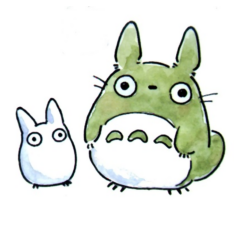

In [9]:
# Improve salt&pepper noise by using xxx filter
improved_sp_img = cv2.medianBlur(sp_img,3)
plt.imshow(improved_sp_img), plt.axis('off')

## Question 3: Other noise removal methods - Non-Local Means Denoising

Apply the Non-Local Means Denoising method. The algorithm replaces the value of a
pixel by an average of a selection of other pixels values. As a result, this algorithm can restore
well textures, that would be blurred by other denoising algorithm.

(<matplotlib.image.AxesImage at 0x7f4814a392d0>, (-0.5, 399.5, 383.5, -0.5))

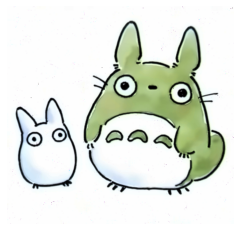

In [10]:
improved_gauss_img = cv2.fastNlMeansDenoisingColored(gauss_img, None,10,10,7,21)
plt.imshow(improved_gauss_img), plt.axis('off')

The parameters are:
*   **src** : Input 8-bit 3-channel image.
*   **dst** : Output image with the same size and type as src .
*   **h** : Parameter regulating filter strength for luminance component. Bigger h value perfectly
removes noise but also removes image details, smaller h value preserves details but also preserves some noise.
*   **hColor** : same as h, but for color images only (normally same as h).
*   **templateWindowSize** : Size in pixels of the template patch that is used to compute weights.
Should be odd. Recommended value 7 pixels
*  **searchWindowSize** : Size in pixels of the window that is used to compute weighted average
for given pixel. Should be odd. Affect performance linearly: greater searchWindowsSize -
greater denoising time. Recommended value 21 pixels 
*   ***Note***: The function converts image to CIELAB colorspace and then separately denoise L and
AB components with given h parameters using fastNlMeansDenoising function.

## Question 4: Applying Wiener Filter for Motion Deblur

In [11]:
# Apply the Wiener filter to perform motion deblur. Run the following functions.
def motion_process(len, size):
    sx, sy = size
    PSF = np.zeros((sy, sx))
    PSF[int(sy / 2):int(sy /2 + 1), int(sx / 2 - len / 2):int(sx / 2 + len / 2)] = 1
    return PSF / PSF.sum()
 
def make_blurred(input, PSF, eps):
    input_fft = np.fft.fft2(input)
    PSF_fft = np.fft.fft2(PSF) + eps
    blurred = np.fft.ifft2(input_fft * PSF_fft)
    blurred = np.abs(np.fft.fftshift(blurred))
    return blurred
 
def wiener(input, PSF, eps):
    input_fft = np.fft.fft2(input)
    PSF_fft = np.fft.fft2(PSF) + eps 
    result = np.fft.ifft2(input_fft / PSF_fft) 
    result = np.abs(np.fft.fftshift(result))
    return result

In [12]:
# Convert the image into grayscale and find the image size.
img_gray =  cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)#Convert the image from RGB to grayscale
(h, w) = img_gray.shape # Find the size of the image

(<matplotlib.image.AxesImage at 0x7f48149a2190>, (-0.5, 399.5, 383.5, -0.5))

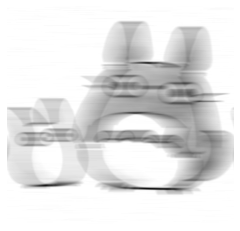

In [13]:
# Perform motion blur on the image using a point spread function (PSF) of 15. You can adjust the PSF value to see different motion blur effects.
PSF = motion_process(46, (w, h))
img_blur = np.abs(make_blurred(img_gray, PSF, 1e-3))
plt.imshow(img_blur, cmap='gray'), plt.axis('off')

(<matplotlib.image.AxesImage at 0x7f48149765d0>, (-0.5, 399.5, 383.5, -0.5))

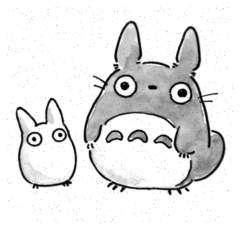

In [14]:
# Perform wiener filter to deblur the image.
result = wiener(img_blur, PSF, 1e-3)
plt.imshow(result, cmap='gray'), plt.axis('off')